In [1]:
#od.download("https://www.kaggle.com/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign")

In [2]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score
np.random.seed(42)

from matplotlib import style
style.use('fivethirtyeight')

In [3]:
data_dir = 'gtsrb-german-traffic-sign'
train_path = data_dir + '/Train'
test_path = data_dir + '/Test'

# Resizing the images to 30x30x3
IMG_HEIGHT = 32
IMG_WIDTH = 32
channels = 3

In [4]:
TOTAL_CATEGORIES = len(os.listdir(train_path))
TOTAL_CATEGORIES

43

In [5]:
# Label Overview
classes = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)', 
            2:'Speed limit (50km/h)', 
            3:'Speed limit (60km/h)', 
            4:'Speed limit (70km/h)', 
            5:'Speed limit (80km/h)', 
            6:'End of speed limit (80km/h)', 
            7:'Speed limit (100km/h)', 
            8:'Speed limit (120km/h)', 
            9:'No passing', 
            10:'No passing veh over 3.5 tons', 
            11:'Right-of-way at intersection', 
            12:'Priority road', 
            13:'Yield', 
            14:'Stop', 
            15:'No vehicles', 
            16:'Veh > 3.5 tons prohibited', 
            17:'No entry', 
            18:'General caution', 
            19:'Dangerous curve left', 
            20:'Dangerous curve right', 
            21:'Double curve', 
            22:'Bumpy road', 
            23:'Slippery road', 
            24:'Road narrows on the right', 
            25:'Road work', 
            26:'Traffic signals', 
            27:'Pedestrians', 
            28:'Children crossing', 
            29:'Bicycles crossing', 
            30:'Beware of ice/snow',
            31:'Wild animals crossing', 
            32:'End speed + passing limits', 
            33:'Turn right ahead', 
            34:'Turn left ahead', 
            35:'Ahead only', 
            36:'Go straight or right', 
            37:'Go straight or left', 
            38:'Keep right', 
            39:'Keep left', 
            40:'Roundabout mandatory', 
            41:'End of no passing', 
            42:'End no passing veh > 3.5 tons' }

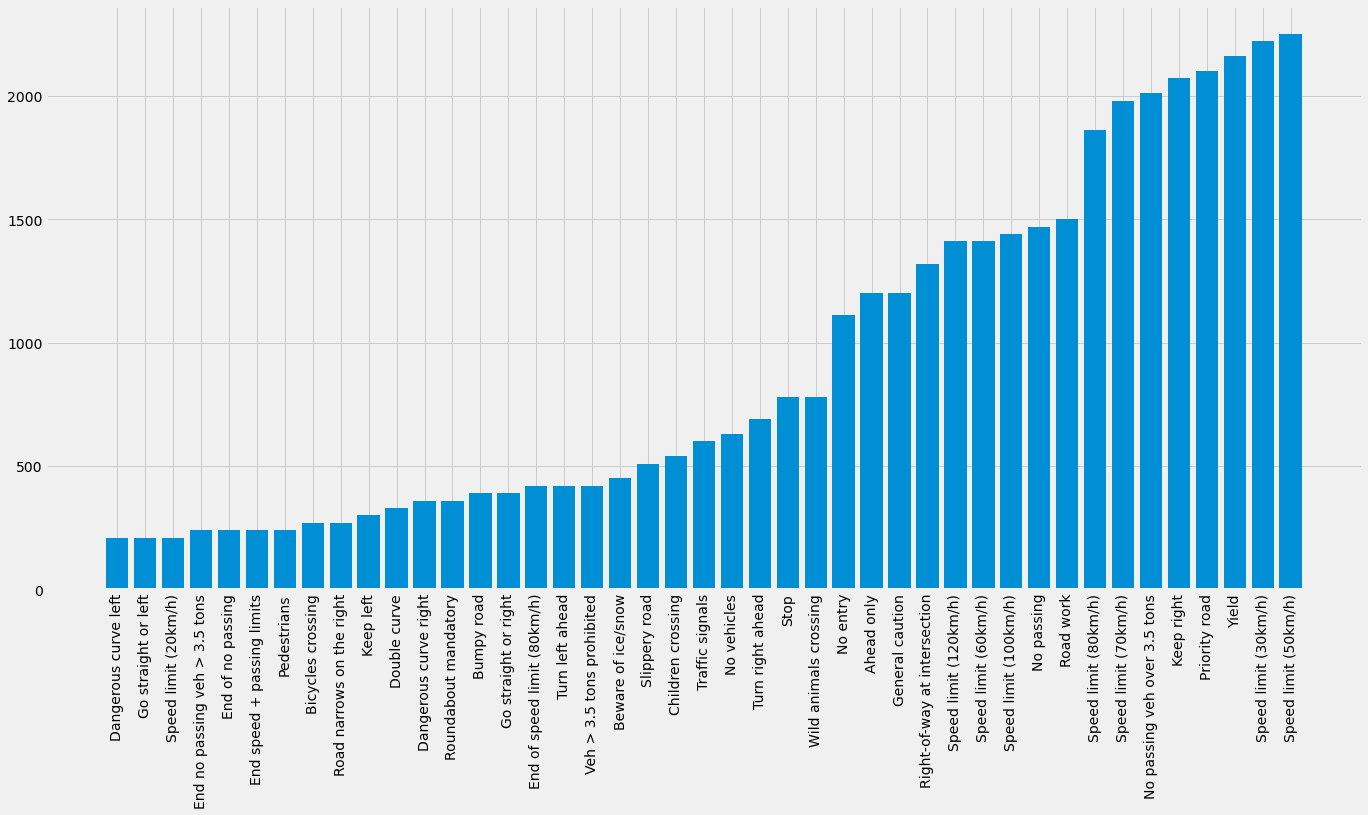

In [6]:
directories = os.listdir(train_path)

train_number = []
class_num = []

for d in directories:
    train_files = os.listdir(train_path + '/' + d)
    train_number.append(len(train_files))
    class_num.append(classes[int(d)])
    
# Sorting the dataset on the basis of number of images in each class
zipped_lists = zip(train_number, class_num)
sorted_pairs = sorted(zipped_lists)
tuples = zip(*sorted_pairs)
train_number, class_num = [ list(tuple) for tuple in  tuples]

# Plotting the number of images in each class
plt.figure(figsize=(21,10))  
plt.bar(class_num, train_number)
plt.xticks(class_num, rotation='vertical')
plt.show()

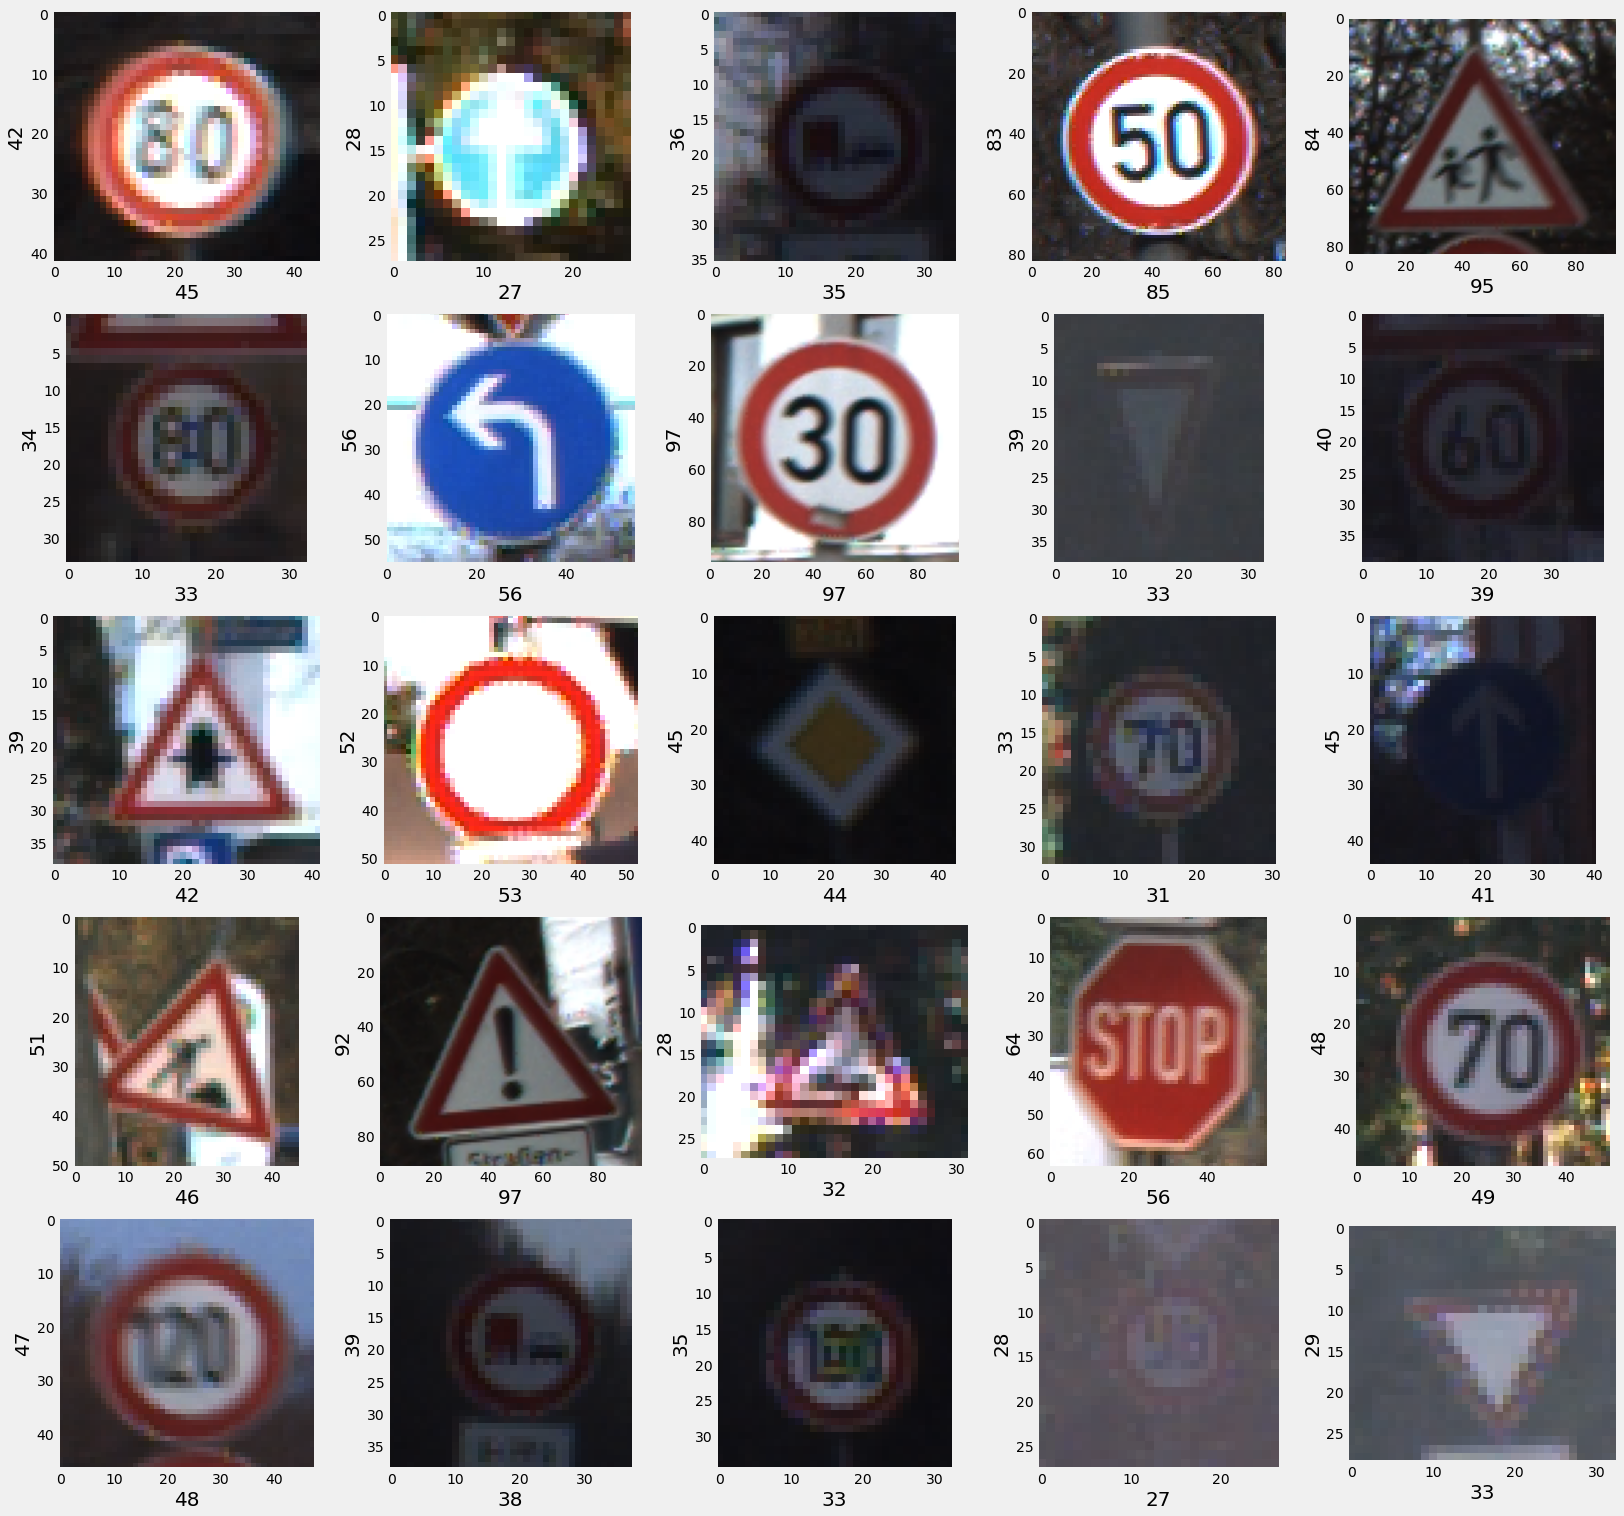

In [7]:
# Visualizing 25 random images from test data
import random
from matplotlib.image import imread

test = pd.read_csv(data_dir + '/Test.csv')
imgs = test["Path"].values

plt.figure(figsize=(25,25))

for i in range(1,26):
    plt.subplot(5,5,i)
    random_img_path = data_dir + "/" + random.choice(imgs)
    rand_img = imread(random_img_path)
    plt.imshow(rand_img)
    plt.grid(b=None)
    plt.xlabel(rand_img.shape[1], fontsize = 20)#width of image
    plt.ylabel(rand_img.shape[0], fontsize = 20)#height of image

In [8]:
image_data = []
image_labels = []

for i in range(TOTAL_CATEGORIES):
    path = data_dir + '/Train/' + str(i)
    images = os.listdir(path)

    for img in images:
        try:
            image = cv2.imread(path + '/' + img)
            image_fromarray = Image.fromarray(image, 'RGB')
            resize_image = image_fromarray.resize((IMG_HEIGHT, IMG_WIDTH))
            image_data.append(np.array(resize_image))
            image_labels.append(i)
        except:
            print("Error in " + img)

# Changing the list to numpy array
image_data = np.array(image_data)
image_labels = np.array(image_labels)

print(image_data.shape, image_labels.shape)

(39209, 32, 32, 3) (39209,)


In [9]:
shuffle_indexes = np.arange(image_data.shape[0])
np.random.shuffle(shuffle_indexes)
image_data = image_data[shuffle_indexes]
image_labels = image_labels[shuffle_indexes]

In [10]:
X_train, X_val, y_train, y_val = train_test_split(image_data, image_labels, test_size=0.3, random_state=42, shuffle=True)

X_train = X_train/255 
X_val = X_val/255

print("X_train.shape", X_train.shape)
print("X_valid.shape", X_val.shape)
print("y_train.shape", y_train.shape)
print("y_valid.shape", y_val.shape)



X_train.shape (27446, 32, 32, 3)
X_valid.shape (11763, 32, 32, 3)
y_train.shape (27446,)
y_valid.shape (11763,)


In [11]:
y_train = keras.utils.to_categorical(y_train, TOTAL_CATEGORIES)
y_val = keras.utils.to_categorical(y_val, TOTAL_CATEGORIES)

print(y_train.shape)
print(y_val.shape)

(27446, 43)
(11763, 43)


In [12]:
model = keras.models.Sequential([    
    keras.layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', input_shape=(IMG_HEIGHT,IMG_WIDTH,channels)),
    keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(axis=-1),
    keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(axis=-1),
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(rate=0.5),
    keras.layers.Dense(43, activation='softmax')
])

In [13]:
lr = 0.001
epochs = 30

opt = Adam(lr=lr, decay=lr / (epochs * 0.5))
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [14]:
aug = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode="nearest")

history = model.fit(aug.flow(X_train, y_train, batch_size=32), epochs=epochs, validation_data=(X_val, y_val))

Epoch 1/30
858/858 [==============================] - 50s 58ms/step - loss: 1.7353 - accuracy: 0.5735 - val_loss: 0.1472 - val_accuracy: 0.9558
Epoch 2/30
858/858 [==============================] - 57s 67ms/step - loss: 0.1641 - accuracy: 0.9506 - val_loss: 0.0996 - val_accuracy: 0.9716
Epoch 3/30
858/858 [==============================] - 63s 74ms/step - loss: 0.0976 - accuracy: 0.9710 - val_loss: 0.0139 - val_accuracy: 0.9961
Epoch 4/30
858/858 [==============================] - 66s 77ms/step - loss: 0.0762 - accuracy: 0.9760 - val_loss: 0.0128 - val_accuracy: 0.9964
Epoch 5/30
858/858 [==============================] - 148s 173ms/step - loss: 0.0601 - accuracy: 0.9817 - val_loss: 0.0092 - val_accuracy: 0.9973
Epoch 6/30
858/858 [==============================] - 147s 171ms/step - loss: 0.0499 - accuracy: 0.9831 - val_loss: 0.0095 - val_accuracy: 0.9978
Epoch 7/30
858/858 [==============================] - 146s 170ms/step - loss: 0.0396 - accuracy: 0.9885 - val_loss: 0.0223 - val_acc

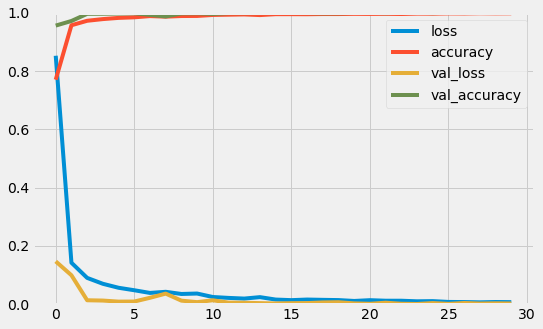

In [15]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [16]:
test = pd.read_csv(data_dir + '/Test.csv')

labels = test["ClassId"].values
imgs = test["Path"].values

data =[]
for img in imgs:
    try:
        image = cv2.imread(data_dir + '/' +img)
        image_fromarray = Image.fromarray(image, 'RGB')
        resize_image = image_fromarray.resize((IMG_HEIGHT, IMG_WIDTH))
        data.append(np.array(resize_image))
    except Exception as e:
        print("Error in " + img)
X_test = np.array(data)
X_test = X_test/255

predict_x=model.predict(X_test) 
classes_x=np.argmax(predict_x,axis=1)

#Accuracy with the test data
print('Test Data accuracy: ',accuracy_score(labels, classes_x)*100)

Test Data accuracy:  98.49564528899447


In [17]:
from sklearn.metrics import classification_report

print(classification_report(labels, classes_x))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        60
           1       0.99      1.00      1.00       720
           2       0.99      0.99      0.99       750
           3       0.99      0.99      0.99       450
           4       1.00      0.99      0.99       660
           5       0.99      0.99      0.99       630
           6       0.99      0.89      0.94       150
           7       0.99      1.00      0.99       450
           8       0.99      1.00      0.99       450
           9       1.00      1.00      1.00       480
          10       1.00      1.00      1.00       660
          11       0.99      0.95      0.97       420
          12       1.00      0.97      0.99       690
          13       1.00      1.00      1.00       720
          14       1.00      1.00      1.00       270
          15       0.99      1.00      0.99       210
          16       1.00      1.00      1.00       150
          17       1.00    

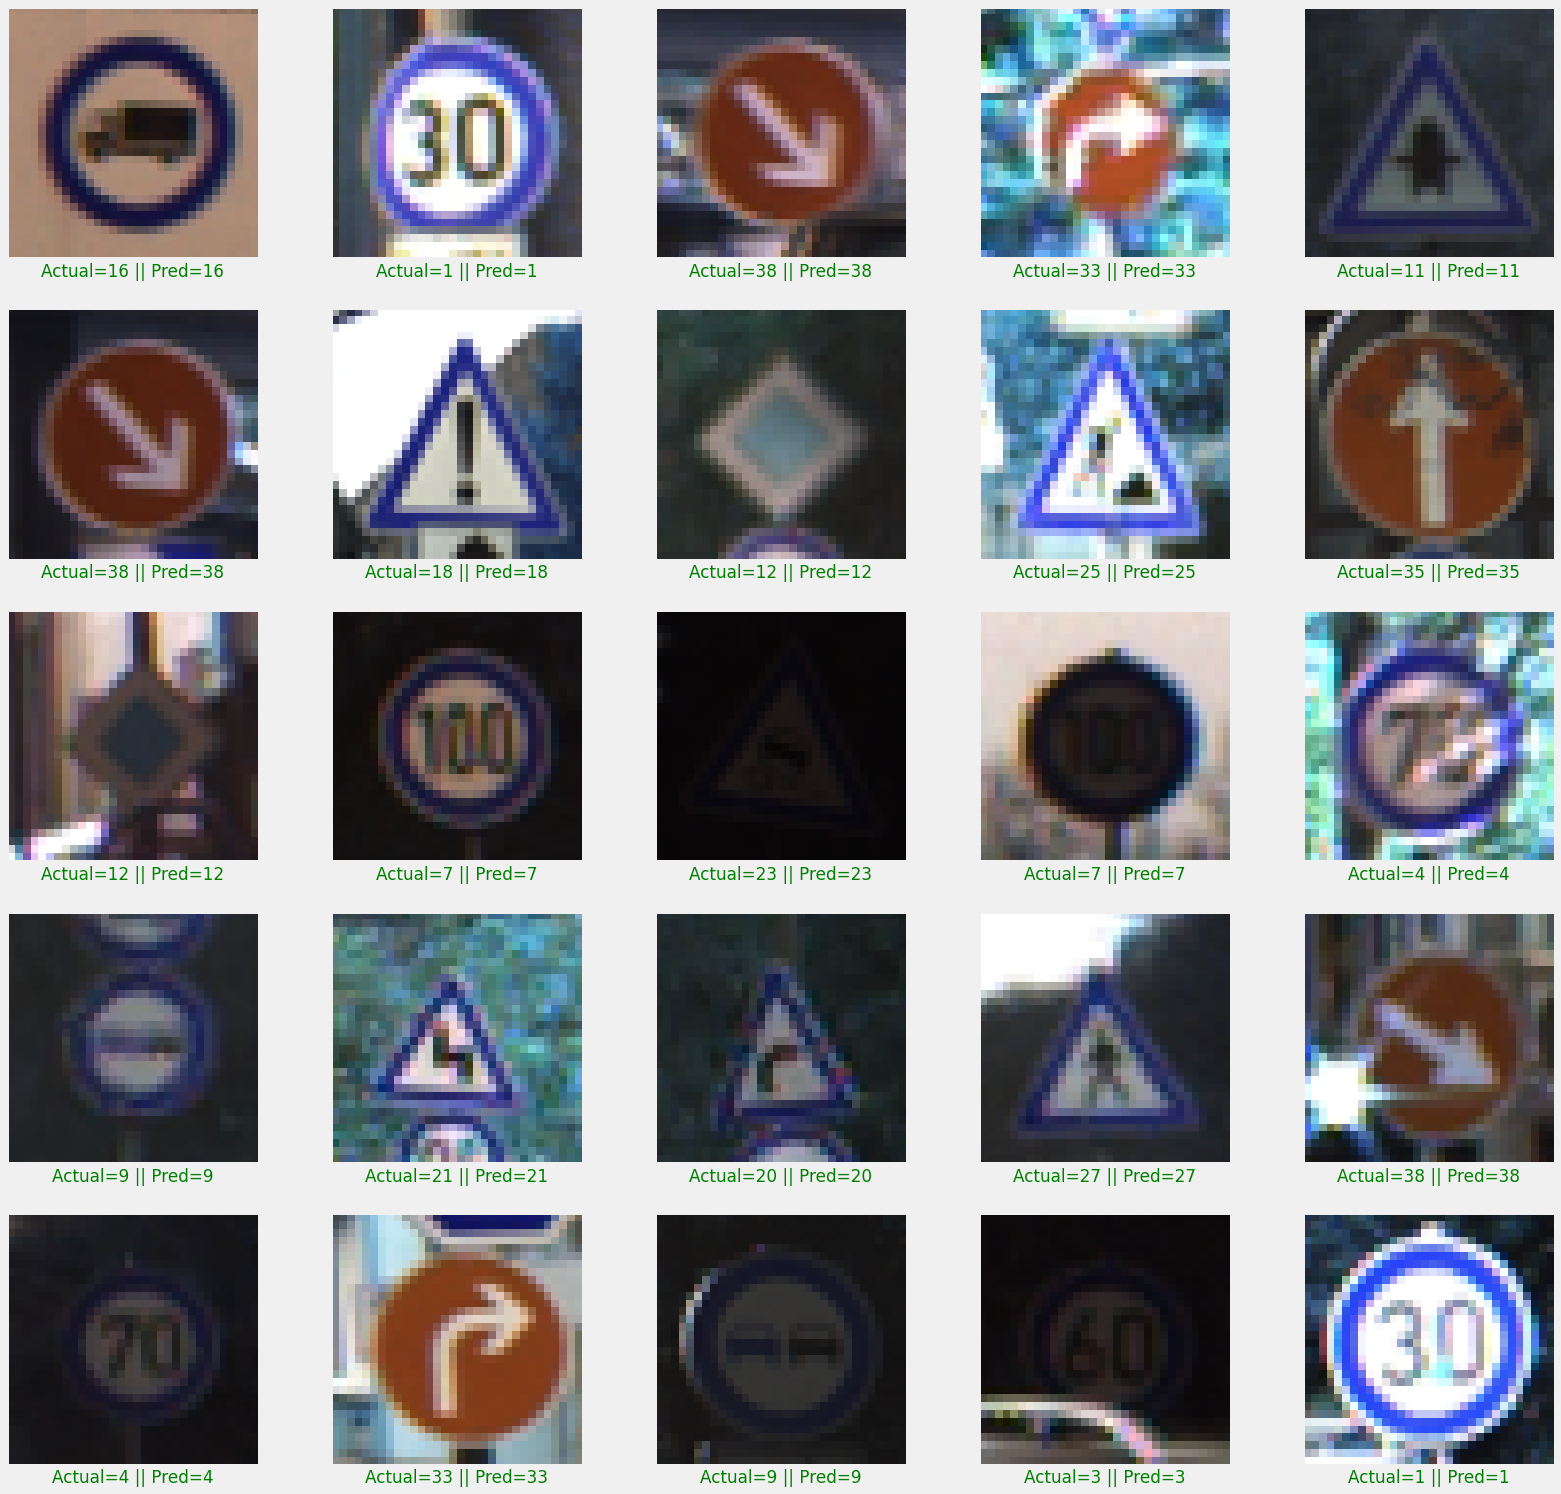

In [18]:
plt.figure(figsize = (25, 25))

start_index = 0
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    prediction = classes_x[start_index + i]
    actual = labels[start_index + i]
    col = 'g'
    if prediction != actual:
        col = 'r'
    plt.xlabel('Actual={} || Pred={}'.format(actual, prediction), color = col)
    plt.imshow(X_test[start_index + i])
plt.show()

In [19]:
model.save('German_traffic_sign.h5')